In [1]:
# -*- coding: utf-8 -*-
"""
Created on 11/15/2018
1. Reads from csv file from the GCaMP imaging data
2. Generates two figures 
   a) raw neuron, raw background, subtracted neuron
   b) deltaF/F0 

@author: Heeun Jang

Adapted by Andrew Rodriguez for individual use
"""

import numpy as np
import pandas as pd
#import scipy as sc
import matplotlib.pyplot as plt
#%matplotlib inline
#import os
import glob
import seaborn as sns
import math

## Edit here for each experiment 
total_sec = 37  
frames_per_sec = 2
frames = np.arange(0, total_sec*frames_per_sec)
# Create a dictionary with key = eid, value = dataframe from each experiment.
directory = r"C:\Users\atomr\Documents\Buck\Jennifer Lab\20221220_heatAtFrameNumAdjustedto11\Quantification with Python script adapted from Heeun"
add_to_filename = "Merged"              
all_files = glob.glob(directory + "/*.csv")
file_list = [] 
df_raw = {} # Dictionary of keys = file name, values = dataframe of raw csv.

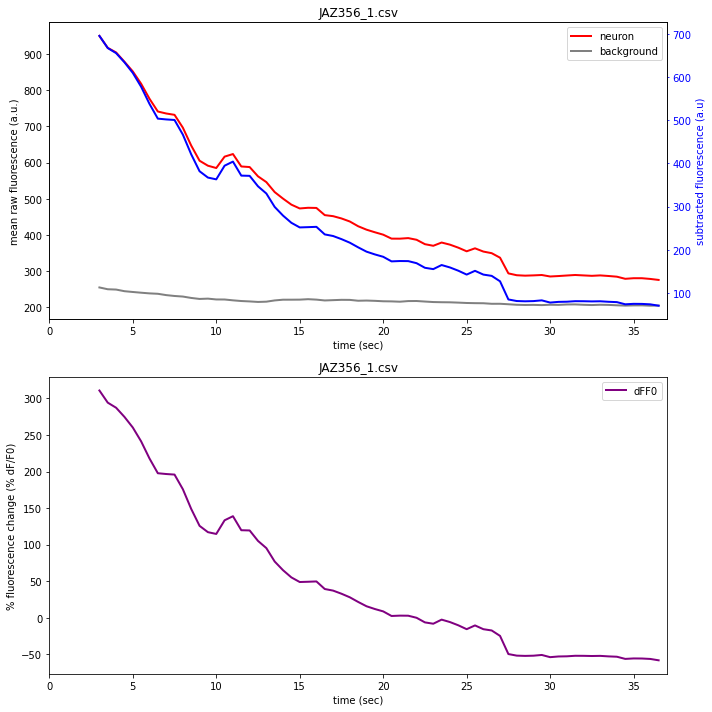

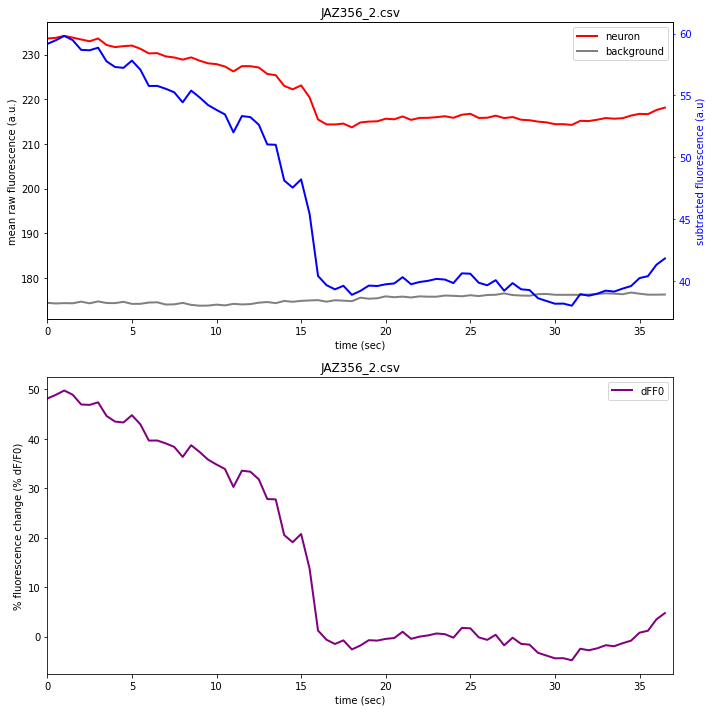

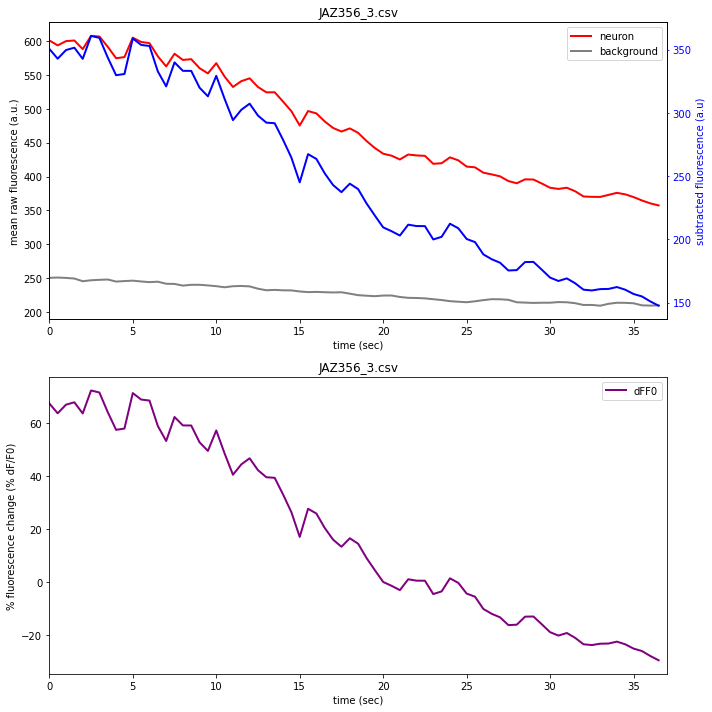

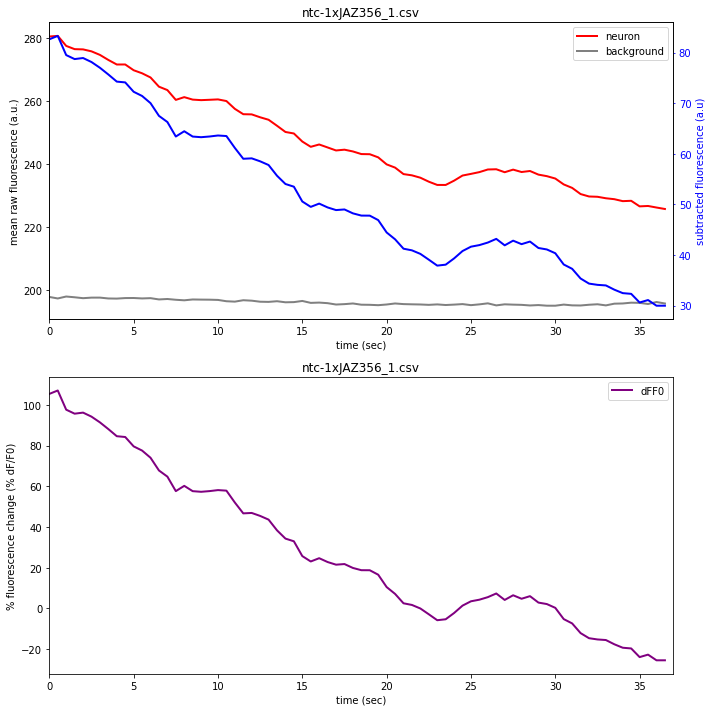

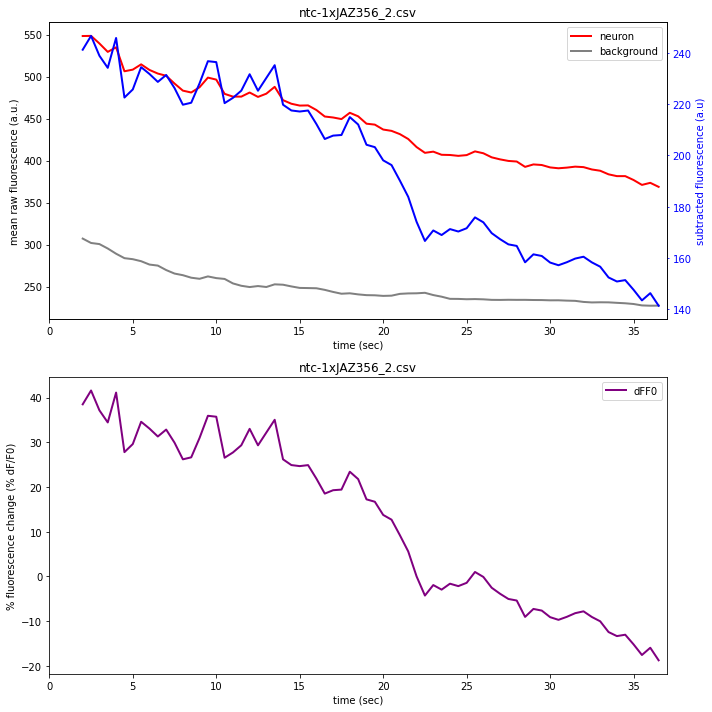

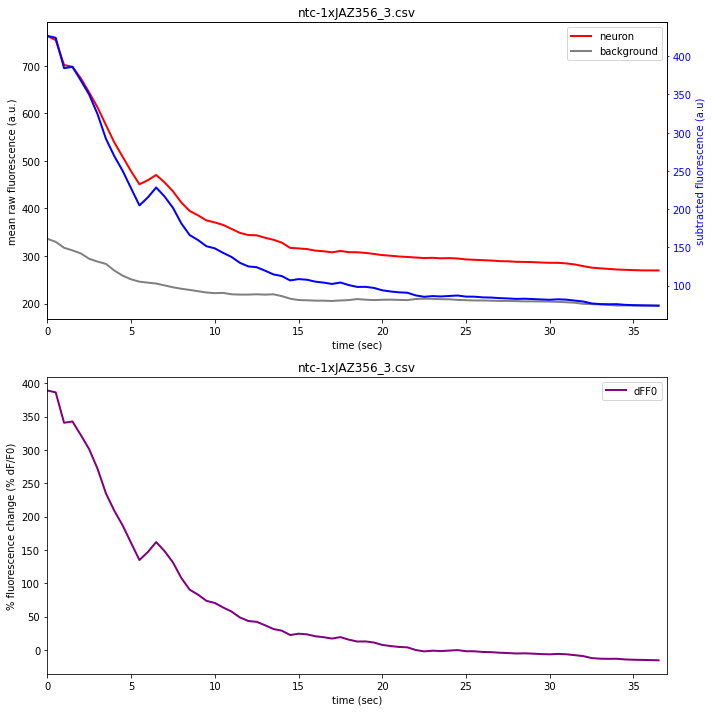

In [2]:
## Go through each file in the directory to get data
for i, file_name in enumerate (all_files):
    file_name_cut = file_name[(len(directory)+1):len(file_name)]
    file_list.append(file_name_cut)
    
    df_raw[file_name_cut] = pd.read_csv(file_name, index_col=None, header=0)
    
#    frame           = np.array(df_raw[file_name_cut]["frame"])
    neuron          = np.array(df_raw[file_name_cut]["neuron"])
    background      = np.array(df_raw[file_name_cut]["background"])
    neuron          = neuron[:300]
    background      = background[:300]
    
    subtract        = neuron - background
    F0              = np.median(subtract[40:49])  
    dFF0            = (subtract - F0)/F0*100

    
    # plot individual graphs    
    fig = plt.figure(figsize = (10,10))

    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1.plot(frames/frames_per_sec, neuron, color = "red", linewidth = 2, label = "neuron")
    ax1.plot(frames/frames_per_sec, background, color = "grey", linewidth = 2, label = "background")
    ax1.set_ylabel("mean raw fluorescence (a.u.)")
    ax1.set_xlim(0, total_sec)
    ax1.set_xlabel("time (sec)")
    ax1.legend()
    ax1.set_title("%s" % file_name_cut)
    
    ax2 = ax1.twinx()
    ax2.plot(frames/frames_per_sec, subtract, color = "blue", linewidth = 2, label = "neuron, bg corrected")
    ax2.set_ylabel("subtracted fluorescence (a.u)", color = 'b')
    ax2.tick_params('y', colors='b', size = 2)
    
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    ax3.plot(frames/frames_per_sec, dFF0, color="purple", linewidth = 2, label = "dFF0")
    ax3.set_xlim(0, total_sec)
    ax3.legend()
    ax3.set_ylabel("% fluorescence change (% dF/F0)")
    ax3.set_xlabel("time (sec)")
    ax3.set_title("%s" % file_name_cut)
    
    plt.tight_layout()
    save_file_path = directory + "/" + file_name_cut + ".png"
    plt.savefig(save_file_path)
    plt.show()
    
    dFF0        = list(dFF0)
    frame_list  = list(frames)
    max_index   = dFF0.index(max(dFF0))
    time_peak   = frame_list[max_index]/frames_per_sec
    dFF0_peak   = max(dFF0)   
       
    if i == 0:
        df_dFF0                     = pd.DataFrame(frames, columns = ["frame"])
        df_dFF0[file_name_cut]      = pd.Series(dFF0) 
        df_time_peak                = pd.Series([time_peak], index = [file_name_cut])
        df_dFF0_peak                = pd.Series([dFF0_peak], index = [file_name_cut])
        df_dFF0_scaled              = pd.DataFrame(dFF0/dFF0_peak, columns = [file_name_cut])

    else: 
        df_dFF0[file_name_cut]      = pd.Series(dFF0)
        df_time_peak_temp           = pd.Series([time_peak], index = [file_name_cut])
        df_dFF0_peak_temp           = pd.Series([dFF0_peak], index = [file_name_cut])
        df_time_peak                = df_time_peak.append(df_time_peak_temp)
        df_dFF0_peak                = df_dFF0_peak.append(df_dFF0_peak_temp)
        df_dFF0_scaled[file_name_cut] = pd.Series(dFF0/dFF0_peak)
    

In [3]:
                                  
## Re-arrange the dataframe according to the peak value
df_dFF0_peak_sorted = df_dFF0_peak.sort_values(ascending = False)

for i, file_name_cut in enumerate(df_dFF0_peak_sorted.index):
    if i ==0:
        df_dFF0_heatmap_sorted = pd.DataFrame(df_dFF0[file_name_cut], columns = [file_name_cut])
        df_dFF0_scaled_sorted  = pd.DataFrame(df_dFF0_scaled[file_name_cut], columns = [file_name_cut])
    else:
        df_dFF0_heatmap_sorted[file_name_cut] = pd.Series(df_dFF0[file_name_cut])
        df_dFF0_scaled_sorted[file_name_cut]  = pd.Series(df_dFF0_scaled[file_name_cut])
## df_dFF0_heatmap = df_dFF0.drop(columns=["frame"])        
df_dFF0_heatmap_sorted = df_dFF0_heatmap_sorted.T      
df_dFF0_scaled_sorted  = df_dFF0_scaled_sorted.T

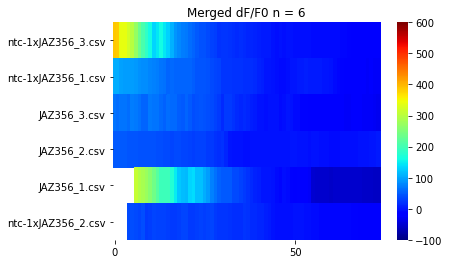

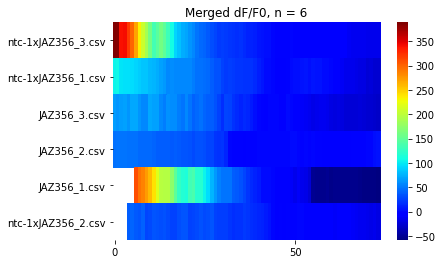

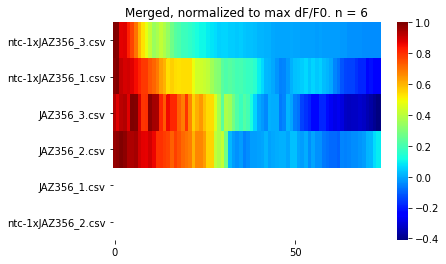

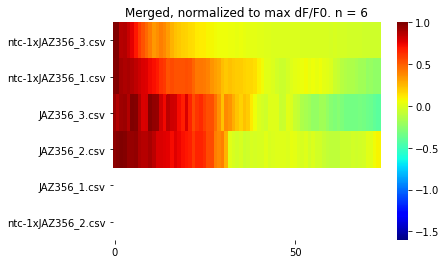

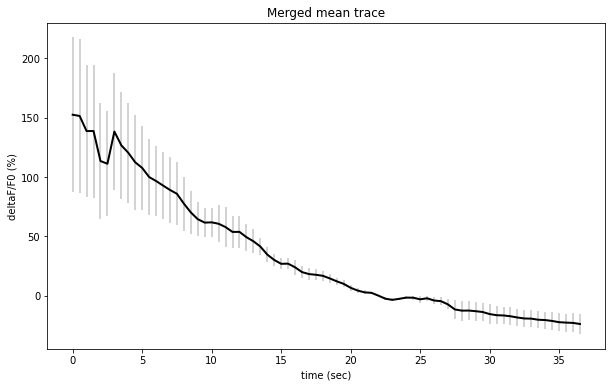

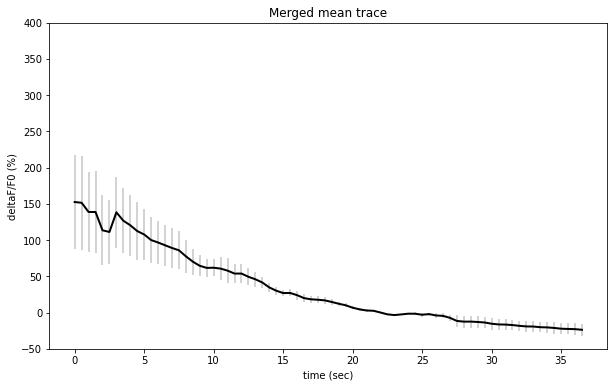

No handles with labels found to put in legend.


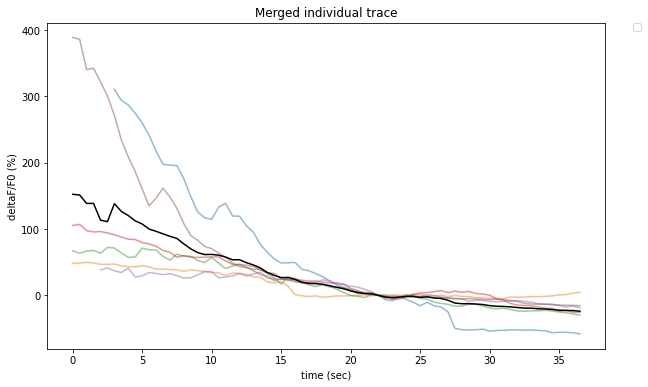

In [4]:
## Heatmap same scale
ax11 = plt.axes()
sns.heatmap(df_dFF0_heatmap_sorted, xticklabels = 50, yticklabels=True, cmap="jet", vmax=600, vmin=-100, ax = ax11)
ax11.set_title("%s dF/F0 n = %d" % (add_to_filename, (i+1)))
save_file_path = directory + "/" + add_to_filename + "_heatmap_same_scale.png"
figure = ax11.get_figure() 
figure.savefig(save_file_path, dpi=1200)
plt.show()

## Heatmap autorange
ax12 = plt.axes()
sns.heatmap(df_dFF0_heatmap_sorted, xticklabels = 50, yticklabels=True, cmap="jet", ax = ax12)
ax12.set_title("%s dF/F0, n = %d" % (add_to_filename, (i+1)))
save_file_path = directory + "/" + add_to_filename + "_heatmap_autorange.png"
figure = ax12.get_figure() 
figure.savefig(save_file_path, dpi=1200)
plt.show()

## Heatmap normalized to max value, autorange
ax13 = plt.axes()
sns.heatmap(df_dFF0_scaled_sorted, xticklabels = 50, yticklabels=True, cmap="jet")
ax13.set_title("%s, normalized to max dF/F0. n = %d" % (add_to_filename, (i+1)))
save_file_path = directory + "/" + add_to_filename + "_heatmap_normalized_aurorange.png"
figure = ax13.get_figure() 
figure.savefig(save_file_path, dpi=1200)
plt.show()

## Heatmap normalized to max value, same scale
ax14 = plt.axes()
sns.heatmap(df_dFF0_scaled_sorted, xticklabels = 50, yticklabels=True, cmap="jet", vmax = 1.0, vmin=-1.6)
ax14.set_title("%s, normalized to max dF/F0. n = %d" % (add_to_filename, (i+1)))
save_file_path = directory + "/" + add_to_filename + "_heatmap_normalized_same_scale.png"
figure = ax14.get_figure() 
figure.savefig(save_file_path, dpi=1200)
plt.show()


## Save csv files               
save_file_path   = directory  + "/" + add_to_filename + "_dFF0.csv"
df_dFF0.to_csv(save_file_path, index=False)
save_file_path   = directory  + "/" + add_to_filename + "_time_to_peak_sec.csv"
df_time_peak.to_csv(save_file_path, index=True)
save_file_path   = directory  + "/" + add_to_filename + "_dFF0_peak.csv"
df_dFF0_peak.to_csv(save_file_path, index=True)


# Calculate mean 
df_dFF0_values = df_dFF0.drop(columns=["frame"])
dFF0_mean      = df_dFF0_values.mean(axis=1)
dFF0_stderr    = df_dFF0_values.std(axis=1)
dFF0_stderr    = dFF0_stderr/math.sqrt(len(all_files))


## Figure of mean trace with standard error 
plt.figure(figsize = (10,6))
plt.errorbar(frames/frames_per_sec, dFF0_mean, dFF0_stderr, linewidth = 2, color = "black", ecolor = "lightgray")    
plt.xlabel("time (sec)")
plt.ylabel("deltaF/F0 (%)")
plt.title("%s mean trace" % add_to_filename)
save_file_path = directory + "/" + add_to_filename + "_mean_stderr_dFF0_autorange.png"
plt.savefig(save_file_path)
plt.show() 

## Figure of mean trace with standard error, same scale
plt.figure(figsize = (10,6))
plt.errorbar(frames/frames_per_sec, dFF0_mean, dFF0_stderr, linewidth = 2, color = "black", ecolor = "lightgray")    
plt.ylim(-50, 400)
plt.xlabel("time (sec)")
plt.ylabel("deltaF/F0 (%)")
plt.title("%s mean trace" % add_to_filename)
save_file_path = directory + "/" + add_to_filename + "_mean_stderr_dFF0_same_scale.png"
plt.savefig(save_file_path)
plt.show() 


## Figure of mean trace with individual traces
plt.figure(figsize = (10,6))
for i, file_name_cut in enumerate (file_list):      
    plt.plot(frames/frames_per_sec, df_dFF0[file_name_cut], alpha = 0.5)
plt.plot(frames/frames_per_sec, dFF0_mean, color = "black")    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("time (sec)")
plt.ylabel("deltaF/F0 (%)")
plt.title("%s individual trace" % add_to_filename)
save_file_path = directory + "/" + add_to_filename + "_indiv_dFF0.png"
plt.savefig(save_file_path)
plt.show()